## Preparation (40 points total)

* [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   
* [15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
* [15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling (50 points total)

* [20 points] Create a convolutional neural network to use on your data using tensorflow. 
* [20 points] Investigate at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the results of the CNNs. 
* [10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.   

## Exceptional Work (10 points total)

You have free reign to provide additional analyses.
One idea: Visualize the convolutional filters chosen by your CNN. Try to interpret some of their meanings.

In [1]:
from keras.datasets import cifar10
from keras.models import Sequential, Input, Model
from keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import keras
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics as mt
import numpy as np
print(keras.__version__)

Using TensorFlow backend.


2.0.3


In [2]:
l2_lambda = 0.0001

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
NUM_CLASSES = 10
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.
)
datagen.fit(x_train)

## Metrics

### Scoring
We need to choose a method for scoring our classifier, out of accuracy, recall, precision, and F-score. For a start, let's define the four possible cases when classifying an image:
* True Positive: Image is of class X, and we correctly guessed class X.
* True Negative: Image is of class X, and we correctly stated that it wasn't any of the other 9 classes. In our cases, a True Positive also comes with the benefit of having 9 True Negatives.
* False Positive: Image is of class X, and we incorrectly guessed class Y.
* False Negative: Image is of class X, and we didn't guess that it was X. Like the True Negative, if we have a False Positive, we also have a False Negative.

In our case, because the True Positives and True Negatives are all paired up with each other, it would be safe to say that we only need to maximize one of them, as maximizing one intrinsically maximizes the other. As such, we can eliminate accuracy score, because we don't need to account for both. Additionally, because having a False Positive means we have a False Negative paired with it, we can weight each equally. We also want to minimize both False Positives and False Negatives. The only scoring method left that takes all these attributes into account is the F-score. In our case, we use the F1 score, as we want to weigh False Positives and Negatives equally. Since Keras removed the f1 scores in their latest version, we reimplemented them as a custom function to pass into our model. 


### Cross-Validation
We also needed to choose a method for splitting our data set into smaller sets that more closely model a real-life scenario, as we don't get to train over every sample of data that comes in before needing to predict what its outcome will be. We have a couple of tools in our arsenal for cross-validation: simple train-test splits, K-folds, shuffle splits, and stratified K-fold or shuffle splits. Coming into the problem, there are a few properties of our dataset that we can use when making this decision. First off, we know that our set is perfectly balanced - there are exactly 6000 members of each class. Secondly, there is no need for any ordering of our set as it's not a time-series or any other ordered series. Lastly, there shouldn't be any bias in the ordering of members of a class. Because of these three characteristics, we believe that we could reliably pick any of the aforementioned techniques and still get good results. However, some of the techniques are intrinsically better than the others. In the interest of time, we use 2 splits of a shuffle split to train our data and perform our graph calculations with the testing data provided by the cifar dataset.

In [4]:
# from keras version < 2.0 https://github.com/fchollet/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7#diff-7b49e1c42728a58a9d08643a79f44cd4L134
from keras import backend as K
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batcwise average of precision.

    Computes the precision, a metric for multlabel classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batcwise average of recall.

    Computes the recall, a metric for multlabel classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
 
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batchwise average, not globally.

    This is useful for multilabel classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The Fbeta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a Fmeasure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

 
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [3]:
# pretty confusion matrices

from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    f1 = mt.f1_score(y_test,yhat, average="macro")
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'F1: {:.4f}'.format(f1)+' Acc: {:.4f}'.format(acc))
    

In [5]:
def plot_roc(probas, y_true):
    plt.figure(figsize=(15,5))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    classes = np.unique(y_true)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for j in classes:
        fpr, tpr, thresholds = mt.roc_curve(y_true, probas[:, j], pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += mt.auc(fpr, tpr)
        plt.plot(fpr,tpr,'--',lw=.5,label='Class ROC for ensemble, AUC=%0.4f'
                     %(mt.auc(fpr, tpr)) )

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr

    plt.plot(mean_fpr,perclass_mean_tpr,'-',lw=2,label='Mean Class ROC for ensemble, AUC=%0.4f'
                     %(roc_auc))
    plt.legend(loc='best')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')
    

In [7]:
from scipy.misc import imresize

x_train_up = [imresize(x,size=(64,64,3), interp='bicubic') for x in x_train]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(64,64,3), interp='bicubic') for x in x_test]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)


## Modeling 



In [32]:
%%time
# build model
lenet = Sequential()
lenet.add(Conv2D(filters=6,kernel_size=(5,5),
               input_shape = (32,32,3), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
lenet.add(Conv2D(filters=16,kernel_size=(5,5), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
lenet.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
#lenet.add(Dropout(0.5))
lenet.add(Conv2D(filters=120,kernel_size=(1,1), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

lenet.add(Flatten())
lenet.add(Dense(84))
lenet.add(Activation("sigmoid"))
lenet.add(Dense(NUM_CLASSES))
lenet.add(Activation('softmax'))
lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy', fmeasure])

# the flow method yields batches of images indefinitely, with the given transformations
cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
for train_index, test_index in cv.split(x_train, y_train_ohe):
    lenet.fit_generator(datagen.flow(x_train[train_index], y_train_ohe[train_index], batch_size=128), 
      steps_per_epoch=int(len(x_train[train_index])/128), # how many generators to go through per epoch
      epochs=25, verbose=2,
      validation_data=(x_train[test_index],y_train_ohe[test_index]),
      callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
     )

Epoch 1/25
23s - loss: 1.7825 - acc: 0.3654 - fmeasure: 0.1487 - val_loss: 1.7572 - val_acc: 0.3913 - val_fmeasure: 0.2065
Epoch 2/25
23s - loss: 1.5133 - acc: 0.4705 - fmeasure: 0.3279 - val_loss: 1.5936 - val_acc: 0.4589 - val_fmeasure: 0.3743
Epoch 3/25
23s - loss: 1.4236 - acc: 0.5011 - fmeasure: 0.3883 - val_loss: 1.3355 - val_acc: 0.5308 - val_fmeasure: 0.4463
Epoch 4/25
23s - loss: 1.3669 - acc: 0.5232 - fmeasure: 0.4273 - val_loss: 1.7203 - val_acc: 0.4401 - val_fmeasure: 0.3830
Epoch 5/25
23s - loss: 1.3234 - acc: 0.5397 - fmeasure: 0.4586 - val_loss: 1.4960 - val_acc: 0.4804 - val_fmeasure: 0.4405
Epoch 6/25
23s - loss: 1.2847 - acc: 0.5527 - fmeasure: 0.4810 - val_loss: 1.3368 - val_acc: 0.5278 - val_fmeasure: 0.4889
Epoch 7/25
22s - loss: 1.2567 - acc: 0.5641 - fmeasure: 0.4998 - val_loss: 1.4525 - val_acc: 0.5042 - val_fmeasure: 0.4325
Epoch 8/25
23s - loss: 1.2280 - acc: 0.5754 - fmeasure: 0.5172 - val_loss: 1.2345 - val_acc: 0.5717 - val_fmeasure: 0.5266
Epoch 9/25
23s -

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


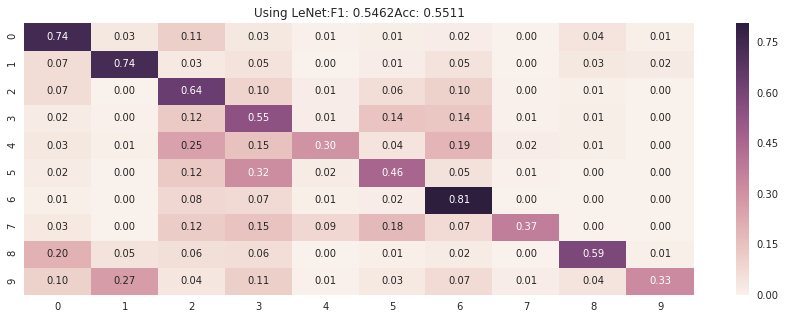

In [39]:
summarize_net(lenet, x_test, y_test, title_text='Using LeNet:')

 9824/10000 [============================>.] - ETA: 0s

/usr/local/es7/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


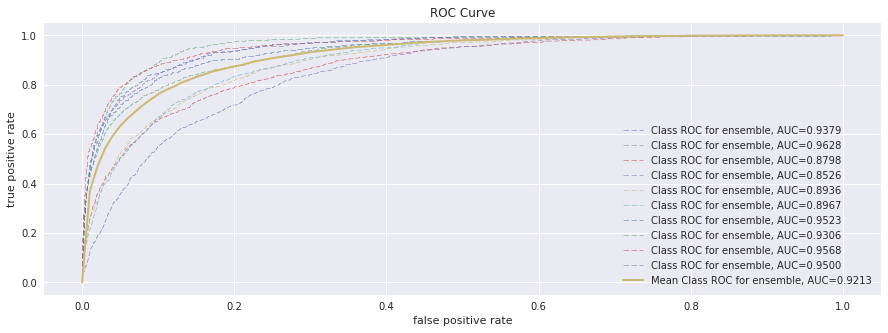

In [38]:
probas = lenet.predict_proba(x_test)
plot_roc(probas, y_test)

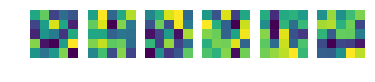

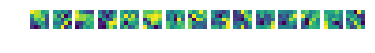

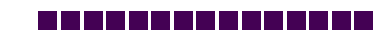

In [6]:
max_plots = 15
for layer in lenet.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()


In [77]:
# Simple CNN model for CIFAR-10
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', fmeasure])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 16, 16)        36928     
__________

In [78]:
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
for train_index, test_index in cv.split(X_train, y_train):
    model.fit(X_train[train_index], y_train[train_index], validation_data=(X_train[test_index], y_train[test_index]), epochs=epochs, batch_size=64)
    # Final evaluation of the model
    scores = model.evaluate(X_train[test_index], y_train[test_index], verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 184s - loss: 2.0081 - acc: 0.2607 - fmeasure: 0.0507 - val_loss: 1.7750 - val_acc: 0.3634 - val_fmeasure: 0.0565
Epoch 2/25
40000/40000 [==============================] - 171s - loss: 1.6162 - acc: 0.4061 - fmeasure: 0.2401 - val_loss: 1.4573 - val_acc: 0.4684 - val_fmeasure: 0.2904
Epoch 3/25
40000/40000 [==============================] - 159s - loss: 1.4097 - acc: 0.4857 - fmeasure: 0.3802 - val_loss: 1.2837 - val_acc: 0.5417 - val_fmeasure: 0.4098
Epoch 4/25
40000/40000 [==============================] - 154s - loss: 1.2652 - acc: 0.5409 - fmeasure: 0.4681 - val_loss: 1.1756 - val_acc: 0.5817 - val_fmeasure: 0.4992
Epoch 5/25
40000/40000 [==============================] - 158s - loss: 1.1569 - acc: 0.5833 - fmeasure: 0.5327 - val_loss: 1.1266 - val_acc: 0.5977 - val_fmeasure: 0.5449
Epoch 6/25
40000/40000 [==============================] - 159s - loss: 1.0604 - acc: 0.6200 - f

KeyboardInterrupt: 

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

summarize_net(model, X_test, y_test, title_text='Using Basic CNN')

In [ ]:
probas = model.predict_proba(X_test)
plot_roc(probas, y_test)

## MLP

We implemented a scikit-learn MLP  

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import _pickle as cPickle
import os
from skimage.feature import daisy

In [7]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./imgs/
###

def get_images(): # stuck this in a function to clean up memory 
    dics = []
    for root, directory, files in os.walk('imgs'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(cPickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('./imgs/batches.meta', 'rb') as fo:
        labels_tmp = cPickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_color, img_gray, img_labels, img_label_names)

img_color, img_gray, img_labels, img_label_names = get_images()
img_gray = img_gray
img_labels = img_labels
print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


In [8]:
daisies = np.array([np.concatenate(np.concatenate(daisy(x.reshape((32,32)), step=16, radius=7, rings=2, histograms=8, orientations=5))) for x in img_gray])

In [9]:
# SKLearn's implementation
x = daisies
y = img_labels
cv = StratifiedShuffleSplit(n_splits=2, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('TLP', MLPClassifier())])
for train_index, test_index in cv.split(x, y):
    pl.fit(x[train_index], y[train_index])
    yhat_mlp = pl.predict(x[test_index])
    print('f1 score:', mt.f1_score(y[test_index], yhat_mlp, average='macro'))
    print(np.bincount(yhat))

f1 score: 0.583064929263


NameError: name 'yhat' is not defined

In [ ]:
plt.figure(figsize=(15,5))
cm = mt.confusion_matrix(y[test_index],yhat_mlp)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title("Using MLP:"+'f1: {:.4f}'.format(0.588)+' acc: {:.4f}'.format(0.588))

In [ ]:
probas = pl.predict_proba(x[test_index])
plot_roc(probas, y[test_index])